# TRPL Curve Fitting
### Exponential
***
This Program will import TRPL decay data, convert the information into data with applicable units, and fit the decay curve.

For fitting these decays, it is useful to plot the data scaled by the natual log, and then use a simple linear curve fit to simplify the process. Single exponential curves can be fit with a straight line.

In [2]:
#Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from scipy.optimize import curve_fit
import math

### Importing the data file
***
We will utilize pandas to read in the txt files of our data.

fileName will be the location of your data file as well as the name, and it will be important to specify the exact file location in order to import the right data.

Once imported and saved to a dataframe, the data will be converted to appropriate units:
- The x-axis will be changed from channels to nanoseconds.
- The y-axis will be scaled logarythmically.

In [3]:
#Importing the Data from text file
df = []
#Put File Name here:
fileName = 'SILAR8_510ex_530fil_644mono.txt'
#Path goes here
path = ''
data = pd.read_csv(path+fileName, header=5, sep='\t')

#Saving the data as lists, in correct units.
x = data['Chan'] * (5.486969*10**-2) #Converting x values from bins to ns
logy = np.log(data['Data'])
for i in logy:
    if math.isnan(i):
        i = 0
y = data['Data']
print('Read in file:', fileName)

Read in file: SILAR8_510ex_530fil_644mono.txt


C:\Users\evanf\anaconda3\envs\general_sci\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
def plot(x, y, title):
    """Takes x and y values and plots them with the proper customization to the plots"""
    
    #Setting the axes and plotting data
    plt.rcParams['figure.figsize'] = [10,8]
    plt.scatter( x, y, c='black', s=4)

    #Plot Customization
    plt.title(title)
    plt.xlabel('time (ns)')
    plt.ylabel('photon counts')

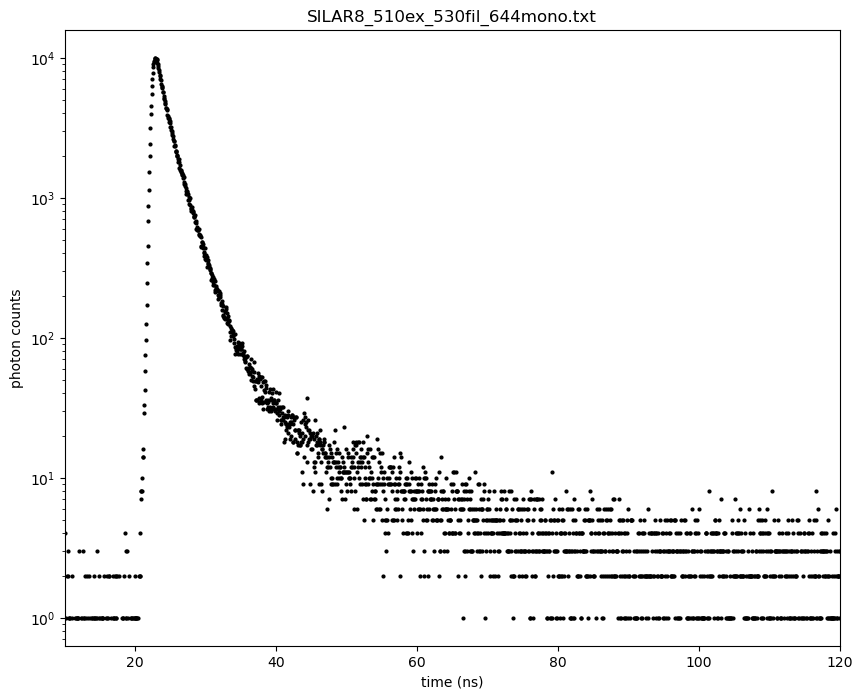

In [12]:
#Plotting the Scatter Plot
plot(x,y, fileName)
plt.yscale('log')
plt.xlim(10,120)
#Saves the file as a png image
#plt.savefig(fileName + '.png')
plt.show()

In [13]:
#Future markdown

### Fitting a Single-Exponential Decay

This group of cells applies to a single-exponential decay curve. It will conduct a linear fit on the data from 15 points past the maximum (to account for the small bump at the peak) and through the next 100 points. 


It is a goal of mine to eventually make this fit automatically select the most accurate point range to fit based on sum of squared residuals and overall error. Right now, I roughly select a portion of the points.

There is a scatter plot that shows the data points as well as the line of fit, and if there is any curve to this, the data range can be manipulated to ensure a straight line and a good fit.

***
We can start by finding the range of the data that we will be fitting, and saving that into a cropped list.

In [31]:
#Finding the maximum value as well as the index this is at
maxval = max(logy)
print(f'The max of the data is {maxval:.2f}, which is {np.exp(maxval):.0f} photon counts.')
y2 = logy.tolist()

maxindex = y2.index(maxval)
t0 = x[maxindex]

#figuring out where to terminate the fitting region
#get the maximum background value - the first 10-ish nanoseconds, before the excitation
#pulse hits
background = np.max(y[0:200]) + 1

#find the first time the data dips below this after the peak
stop = list((y//background)).index(0, maxindex)

#Making lists for the line we are fitting
x2 = data['Chan'].tolist()
fitx = np.array([i*(5.486969*10**-2) for i in range(0, stop-maxindex)])
fity = np.array(logy[maxindex:stop])

The max of the data is 9.21, which is 10001 photon counts.


***
With the data now, we can fit the slope, and get the linear line that best fits the scatter plot.

The slope is -0.1991, with a y-intercept of 7.53
The sum of squared residuals is 286.4155
The variance of the slope is 9.3894e-06


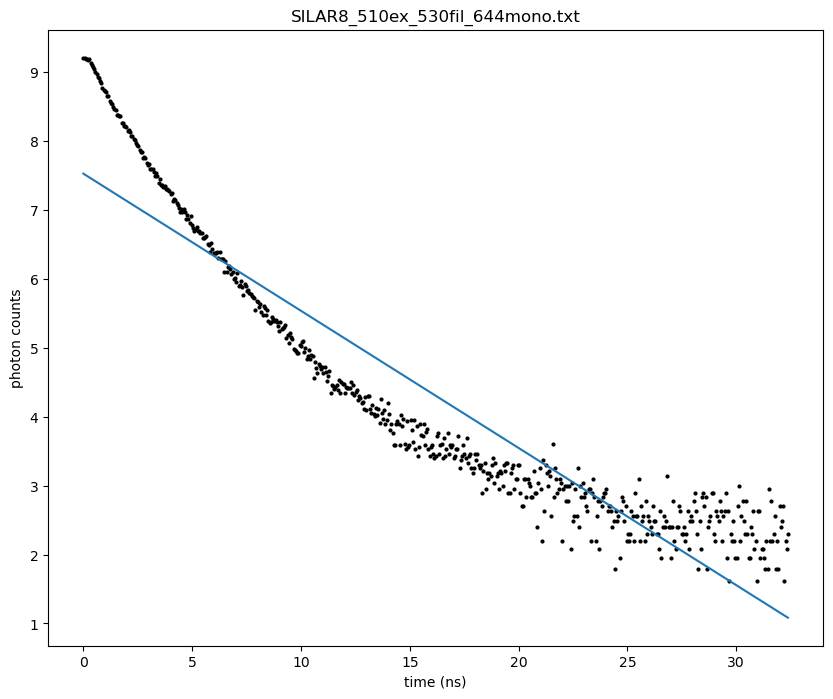

In [32]:
#Plotting the portion of the graph to fit
plot(fitx,fity,fileName)

#Fitting the Data
a = 1.0
m = np.polyfit(fitx, fity, 1, full=False, cov=True)
k,b = m[0] #k is the slope, b is the y-intercept
#ssr = m[1] #ssr is the sum of squared residuals, a way to check the goodness of fit.
t0 = fitx[0]

#Applying the slope to make y points
slopey = []
for i in fitx:
    slopey.append(k*i + b)

#calculate ssr manually
ssr = sum([(slopey[i] - fity[i])**2 for i in range(0, len(fitx))])

#Plotting the fit line
plt.plot(fitx, slopey)
print(f'The slope is {k:.4f}, with a y-intercept of {b:.2f}')
print(f'The sum of squared residuals is {ssr:.4f}')
print(f'The variance of the slope is {m[1][0,0]:.4e}')

### Chi-Squared Calculation
    
    

In [10]:
def chisq(x, act, exp):
    """Calculates the chi-squared value based on the expected slope compared with the actual points."""
    
    chi = 0
    
    for i in range(0,len(x)-1):
        val = ((act[i] - exp[i])**2)/exp[i]
        chi = chi + val
    print(chi)
    return chi

In [11]:
chisquared = chisq(fitx, fity, slopey)
print(f'The chi-squared statistic is {chisquared:.10f}' )

0.13551314413670185
The chi-squared statistic is 0.1355131441


### Solving for Lifetime.

The slope of the line is related to the lifetime via:

$$e^{kt}=e^{-\frac{t}{\tau}}$$
$$\tau=-\frac{1}{k}$$

In [12]:
tau=-1/k
print(f'The lifetime of the material is {tau:.4f} ns.')

#lifetime uncertainty
slope_sd = np.sqrt(m[1][0,0])

tau_sd = 1/(k - slope_sd) - 1/(k + slope_sd)
print("the uncertainty in lifetime is {0:.4e} ns".format(tau_sd))

The lifetime of the material is 2.2353 ns.
the uncertainty in lifetime is 3.2169e-02 ns
